# CSP Features 

### Steps of FB-CSP Classification 
(Fast EEG-Based Decoding Of The Directional Focus Of Auditory Attention Using Common Spatial Patterns)
- Step 1: Filter Bank
    - 14(B is number of filter bank) 8th-order butterworth filters. The first filter corresponds to frequency band 1-4 hz. The second with 2-6. And continuous with overlap 2 hz until 26(2+12*2)-30 hz. 
    - Downsample to 64 hz. (先不做)
- Step 2: CSP
    - How to choice the filter? RMOE (in this paper) vs. Covariance (mne, or common methods)
    - Choice k components from CSP filter
- Step 3: Log Energy
    - Summation the CSP pattern and calculate the log energy of every band and k filters
    - Output feature: Filter Bank B x k components
    - This step will be done by mne.decoding.csp.
- Step 4: Classification  
    - lda, svm

### Data pipline or workflow
Theres two task of the works. Binary classification vs. Multi-class
First in single classes
- Data Prepration: 
    - Input Data: 2(class) x 25(subjects) x 32/2(trials, unknown?) x channel num x trials timepoint
    - Output Data: channel num x 2(class) x segments numbers[subjects x trials x decision windows numbers] x decision windows size (4sec x 128hz)
- Step 1: Filter Bank
    - Input Data: (channel num, 2 x segments numbers, 512)
    - Ouput Data: 2, segments numbers, 14 bank num, 512
- Step 2: CSP
    - Input Data: (s)

### Step 1 - Data Prepration

In [1]:
import mne
import h5py
import numpy as np
import os
import scipy.io
import pandas as pd

# 使用範例
path = "./NJUNCA_preprocessed_arte_removed/"
expinfo_path = path + "expinfomat_csvs/"
mat_files = [f for f in os.listdir(path) if f.endswith('.mat')]
print(mat_files)    # 前兩個是info資料從第三個開始讀

subjects = 21
fs = 128  # sampling frequency
window_sec = 4
window_size = fs * window_sec  # 512
channels = 32  # assume full 32 channels
side_dict = {
    "right": 0,
    "left": 1,
}


# Simulate data
all_segments = []
all_labels = []

for subj in range(2, subjects):
    data_path = path + mat_files[subj]
    file = h5py.File(data_path, 'r')
    csv_path = expinfo_path + mat_files[subj].replace('.mat', '.csv')
    df = pd.read_csv(csv_path)['attended_lr']

    ref_data = file['data']
    ref_eeg = ref_data['eeg']
    ref_leftangle = ref_data['event']['leftWav']
    ref_rightangle = ref_data['event']['rightWav']
    ref_attenside = ref_data['event']['eeg']
    trials = len(ref_eeg[:])

    for trial in range(trials):
        try:
            left_angel_reg = file[ref_leftangle['value'][trial][0]]
            left_angel = file[left_angel_reg[0][0]][0][0]
            right_angel_reg = file[ref_rightangle['value'][trial][0]]
            right_angel = file[right_angel_reg[0][0]][0][0]

            if (left_angel*-1) != right_angel:
                continue

            ref = ref_eeg[trial][0]
            eeg_data = np.array(file[ref][:]) # shape: 32, time
            trial_len = eeg_data.shape[1]
            
            # Segment into 4-second windows (non-overlapping)
            n_windows = trial_len // window_size
            
            for win in range(n_windows):
                segment = eeg_data[:, win * window_size : (win + 1) * window_size]  # shape: (channels, 512)
                all_segments.append(segment)
                all_labels.append(side_dict[df[trial]])
        except:
            print(mat_files[subj], trial, 'load error')


# Convert to numpy arrays
X = np.stack(all_segments)  # shape: (total_segments, channels, 512)
y = np.array(all_labels)    # shape: (total_segments,)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)

n_epochs, n_channels, n_times = X.shape
sfreq = 128  # sampling frequency

# 建立 channel info
# 你給的通道名稱
ch_names = [
    'Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1',
    'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6',
    'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2'
]
ch_types = ['eeg'] * n_channels
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# 建立 event array
# MNE 的 events shape 是 (n_epochs, 3)，通常中間值無用
# 最後一欄是 class label，需要轉換成 event id 後對應 dict
events = np.column_stack((
    np.arange(len(y)),  # arbitrary sample indices
    np.zeros(len(y), dtype=int),  # filler
    y
))

# 建立 event_id 字典
event_id = {f'class_{i}': i for i in np.unique(y)}

# 轉成 EpochsArray
epochs = mne.EpochsArray(X, info, events=events, event_id=event_id, verbose=False)
montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)

# 檢查一下
print(epochs)
# epochs.plot(n_epochs=5, n_channels=10)

['azimuthmat.mat', 'expinfomat.mat', 'S02.mat', 'S03.mat', 'S04.mat', 'S06.mat', 'S07.mat', 'S09.mat', 'S12.mat', 'S13.mat', 'S15.mat', 'S16.mat', 'S17.mat', 'S18.mat', 'S19.mat', 'S21.mat', 'S22.mat', 'S23.mat', 'S25.mat', 'S26.mat', 'S27.mat']
S23.mat 8 load error
S23.mat 21 load error
Data shape: (6755, 32, 512)
Labels shape: (6755,)
<EpochsArray | 6755 events (all good), 0 – 3.992 s (baseline off), ~844.4 MB, data loaded,
 'class_0': 3391
 'class_1': 3364>


### Training set and testing set

In [4]:
from sklearn.model_selection import train_test_split

# # 先產生 train/test 的 index
# train_idx, test_idx = train_test_split(np.arange(len(epochs)), test_size=0.2, stratify=y, random_state=42)

# # 使用 MNE 的索引方式選出對應 epoch
# train_epochs = epochs[train_idx].copy()
# test_epochs = epochs[test_idx].copy()
# train_y = y[train_idx]
# test_y = y[test_idx]

totl_len = len(epochs)
train_epochs = epochs[:int(totl_len*0.8)].copy()
test_epochs = epochs[int(totl_len*0.8)+1:].copy()
train_y = y[:int(totl_len*0.8)]
test_y = y[int(totl_len*0.8)+1:]

# 確認 shape
print("Train epochs:", train_epochs)
print("Test epochs:", test_epochs)

Train epochs: <EpochsArray | 5404 events (all good), 0 – 3.992 s (baseline off), ~675.5 MB, data loaded,
 'class_0': 2717
 'class_1': 2687>
Test epochs: <EpochsArray | 1350 events (all good), 0 – 3.992 s (baseline off), ~168.8 MB, data loaded,
 'class_0': 673
 'class_1': 677>


### Step 2 - CSP and Log Power

In [ ]:
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

bands = {
    '1': (1, 4),
    '2': (2, 6),
    '3': (4, 8),
}
for iter_ in range(4, 15):
    pre_low, pre_high = bands[str(iter_-1)]
    bands[str(iter_)] = (pre_low+2, pre_high+2)

csp_list = []
train_features = []
test_features = []

for name, (l_freq, h_freq) in bands.items():
    # Band-pass filter
    train_epochs_band = train_epochs.copy().filter(l_freq, h_freq, fir_design='firwin').get_data(copy=False)
    test_epochs_band = test_epochs.copy().filter(l_freq, h_freq, fir_design='firwin').get_data(copy=False)

    # Fit CSP on this band
    csp = CSP(n_components=6, reg='ledoit_wolf')
    train_csp = csp.fit_transform(train_epochs_band, train_y)  # labels: array of class labels
    csp_list.append(csp)
    test_csp = csp.transform(test_epochs_band)

    train_features.append(train_csp)
    test_features.append(test_csp)

train_CSP_features = np.concatenate(train_features, axis=1)
test_CSP_features = np.concatenate(test_features, axis=1)

print(train_CSP_features.shape, test_CSP_features.shape)

{'1': (1, 4), '2': (2, 6), '3': (4, 8), '4': (6, 10), '5': (8, 12), '6': (10, 14), '7': (12, 16), '8': (14, 18), '9': (16, 20), '10': (18, 22), '11': (20, 24), '12': (22, 26), '13': (24, 28), '14': (26, 30)}
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   45.6s finished


Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    5.9s finished


Computing rank from data with rank=None
    Using tolerance 3.8e+02 (2.2e-16 eps * 32 dim * 5.4e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 2 - 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 6.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   52.0s finished


Setting up band-pass filter from 2 - 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 6.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    7.9s finished


Computing rank from data with rank=None
    Using tolerance 3.5e+02 (2.2e-16 eps * 32 dim * 4.9e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   53.3s finished


Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    7.9s finished


Computing rank from data with rank=None
    Using tolerance 2.9e+02 (2.2e-16 eps * 32 dim * 4.1e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 6 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   51.0s finished


Setting up band-pass filter from 6 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    8.0s finished


Computing rank from data with rank=None
    Using tolerance 3.9e+02 (2.2e-16 eps * 32 dim * 5.5e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   51.7s finished


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    7.8s finished


Computing rank from data with rank=None
    Using tolerance 4e+02 (2.2e-16 eps * 32 dim * 5.6e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 10 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 169 samples (1.320 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   43.7s finished


Setting up band-pass filter from 10 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 169 samples (1.320 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    5.9s finished


Computing rank from data with rank=None
    Using tolerance 3.6e+02 (2.2e-16 eps * 32 dim * 5.1e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   42.8s finished


Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    5.5s finished


Computing rank from data with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 32 dim * 3.3e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 121 samples (0.945 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   47.9s finished


Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 121 samples (0.945 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    6.6s finished


Computing rank from data with rank=None
    Using tolerance 1.8e+02 (2.2e-16 eps * 32 dim * 2.5e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 107 samples (0.836 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   46.3s finished


Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 107 samples (0.836 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    6.3s finished


Computing rank from data with rank=None
    Using tolerance 1.7e+02 (2.2e-16 eps * 32 dim * 2.3e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 95 samples (0.742 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   45.9s finished


Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 95 samples (0.742 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    6.1s finished


Computing rank from data with rank=None
    Using tolerance 1.6e+02 (2.2e-16 eps * 32 dim * 2.3e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 20 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 85 samples (0.664 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   51.0s finished


Setting up band-pass filter from 20 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 85 samples (0.664 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    7.6s finished


Computing rank from data with rank=None
    Using tolerance 1.5e+02 (2.2e-16 eps * 32 dim * 2.2e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 22 - 26 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 22.00
- Lower transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 19.25 Hz)
- Upper passband edge: 26.00 Hz
- Upper transition bandwidth: 6.50 Hz (-6 dB cutoff frequency: 29.25 Hz)
- Filter length: 77 samples (0.602 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   50.6s finished


Setting up band-pass filter from 22 - 26 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 22.00
- Lower transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 19.25 Hz)
- Upper passband edge: 26.00 Hz
- Upper transition bandwidth: 6.50 Hz (-6 dB cutoff frequency: 29.25 Hz)
- Filter length: 77 samples (0.602 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    7.4s finished


Computing rank from data with rank=None
    Using tolerance 1.5e+02 (2.2e-16 eps * 32 dim * 2.1e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 24 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 24.00
- Lower transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 21.00 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 71 samples (0.555 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   52.2s finished


Setting up band-pass filter from 24 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 24.00
- Lower transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 21.00 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 71 samples (0.555 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    7.7s finished


Computing rank from data with rank=None
    Using tolerance 1.5e+02 (2.2e-16 eps * 32 dim * 2.1e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 26 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 26.00
- Lower transition bandwidth: 6.50 Hz (-6 dB cutoff frequency: 22.75 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 65 samples (0.508 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172928 out of 172928 | elapsed:   51.3s finished


Setting up band-pass filter from 26 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 26.00
- Lower transition bandwidth: 6.50 Hz (-6 dB cutoff frequency: 22.75 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 65 samples (0.508 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 43200 out of 43200 | elapsed:    7.4s finished


Computing rank from data with rank=None
    Using tolerance 1.4e+02 (2.2e-16 eps * 32 dim * 2e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
(5404, 84) [[-4.50167303 -2.35597867 -1.6185189  ... -1.2307372  -2.53716617
  -1.25948421]
 [-4.4190748  -3.19252293 -2.06577314 ... -1.02992665 -2.60301204
  -1.17816411]
 [-4.00314516 -2.87664234 -2.2964145  ... -1.02132877 -2.99009925
  -1.17843672]
 ...
 [-0.92837869 -1.81271328 -2.6646011  ... -1.94971622 -1.52793452
  -1.27845238]
 [-0.23043167 -2.01541225 -2.34639326 ... -2.06943296 -1.39910852
  -1.22618284]
 [-0.52147509 -1.23566412 -2.5906456  ... -2.0852527  -1.60136873
  -1.05789288]]


### Step 3 - Classification

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
cv = ShuffleSplit(10, test_size=0.2, random_state=42)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
svc = svm.SVC()

scores = cross_val_score(svc, train_CSP_features, train_y, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(y == y[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

svc.fit(train_CSP_features, train_y)
pred_y = svc.predict(test_CSP_features)
print(classification_report(test_y, pred_y))
# plot CSP patterns estimated on full data for visualization
# csp.fit_transform(epochs_data, labels)

# csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Classification accuracy: 0.8113783533765032 / Chance level: 0.5019985196150999
              precision    recall  f1-score   support

           0       0.52      0.60      0.56       673
           1       0.53      0.44      0.48       677

    accuracy                           0.52      1350
   macro avg       0.52      0.52      0.52      1350
weighted avg       0.52      0.52      0.52      1350



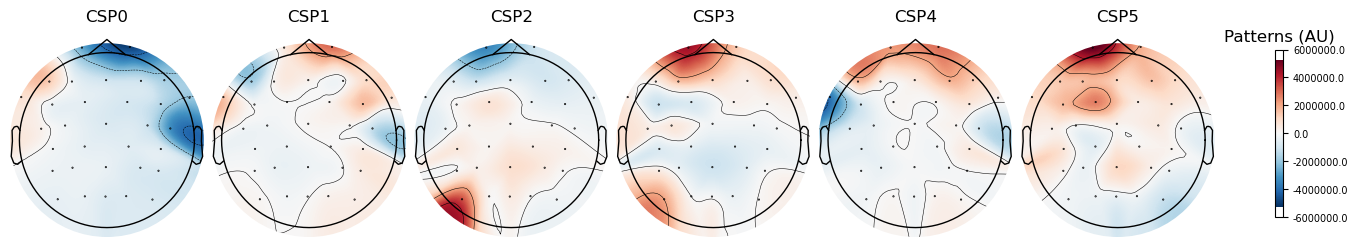

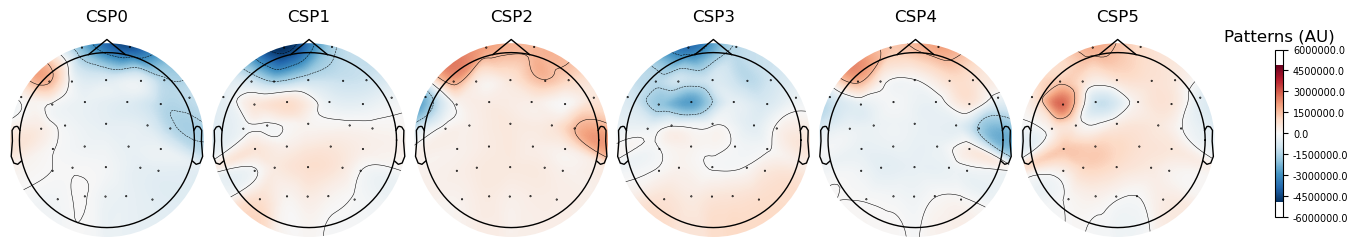

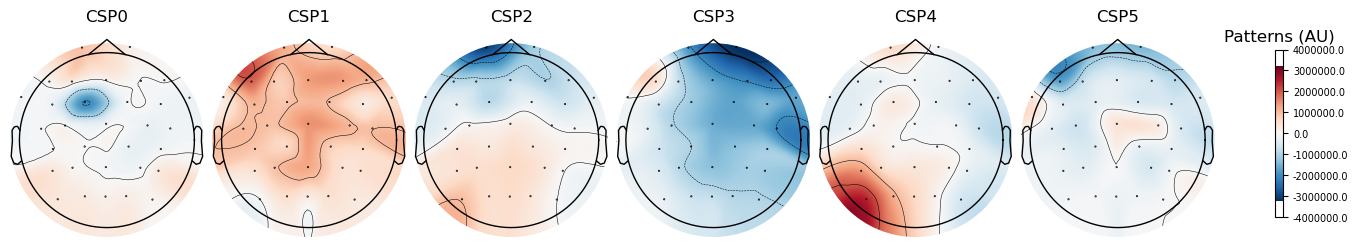

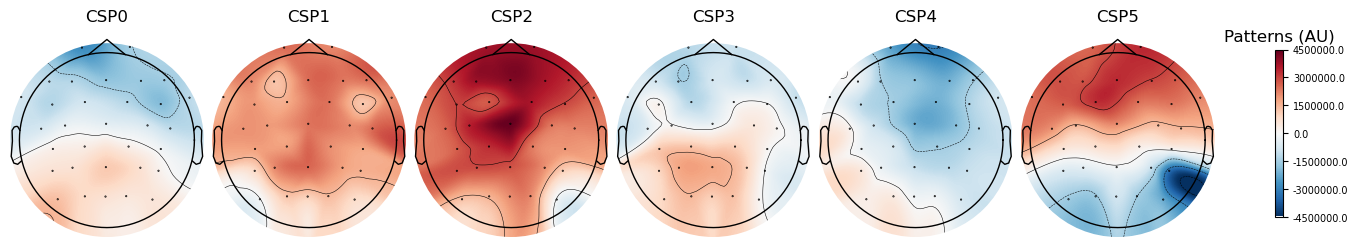

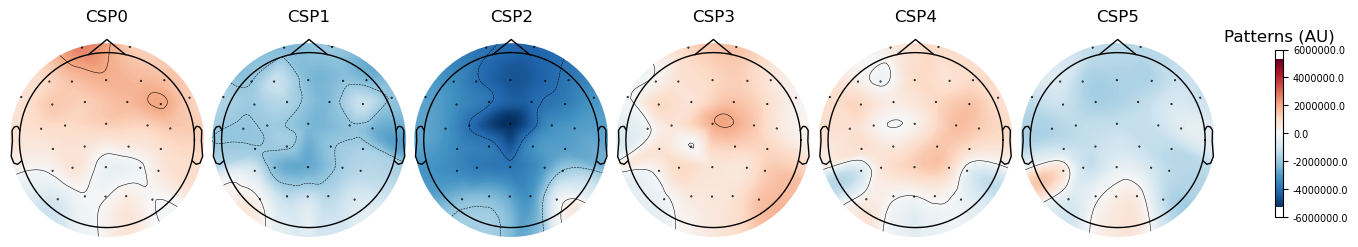

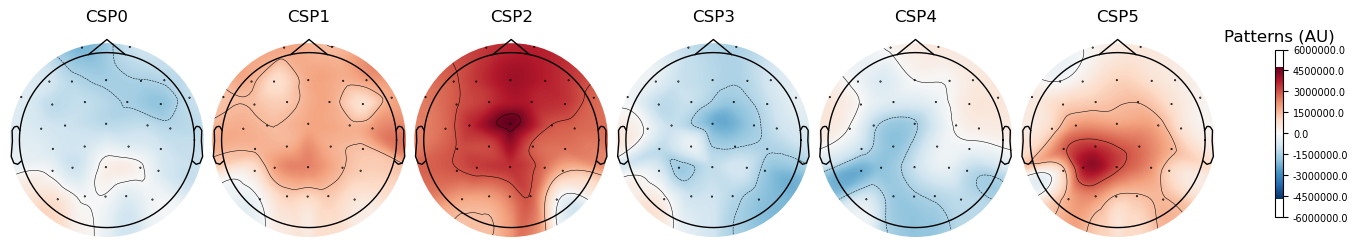

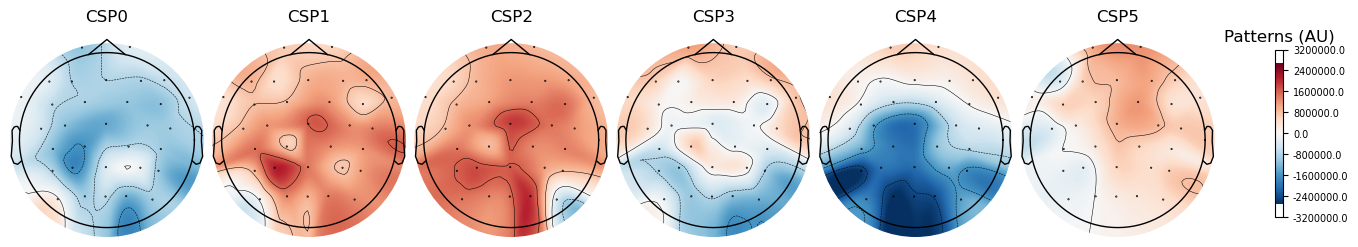

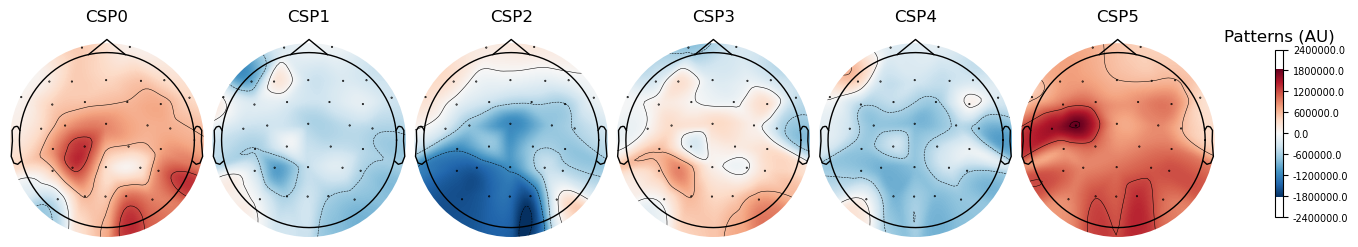

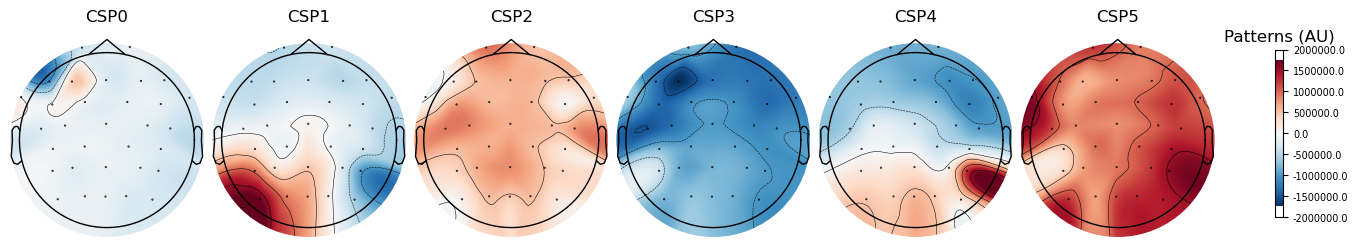

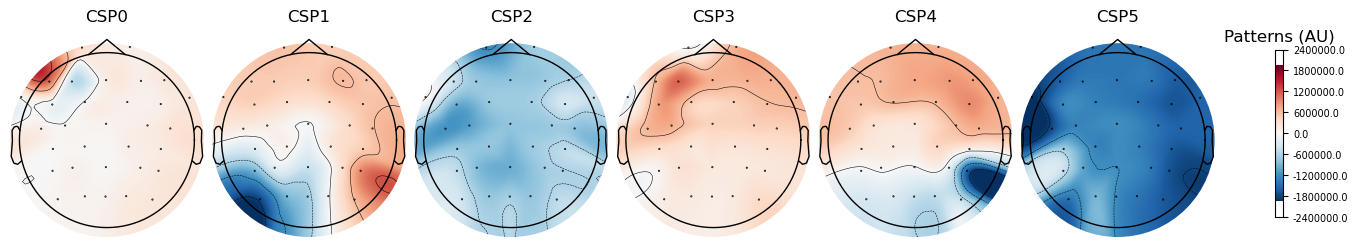

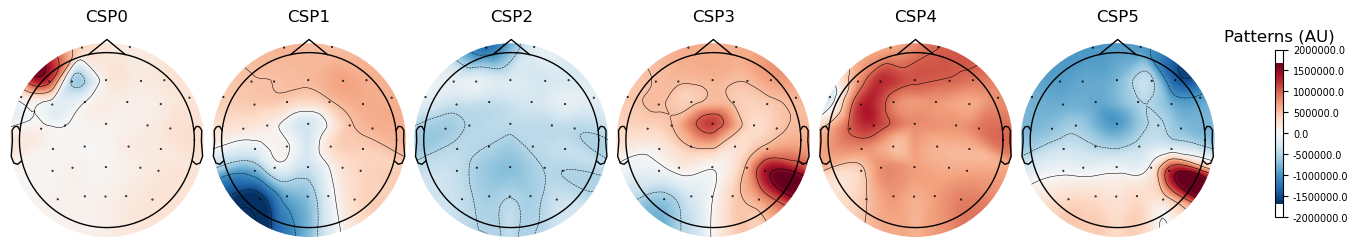

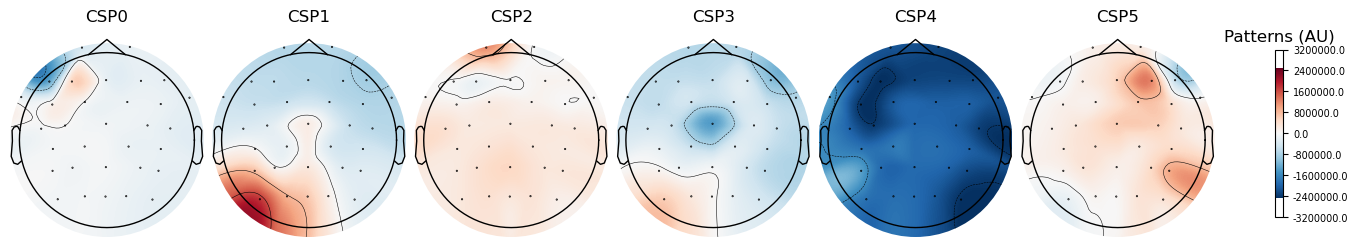

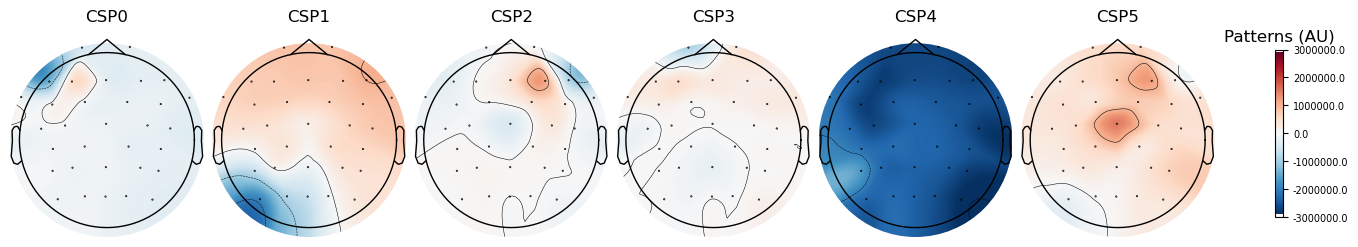

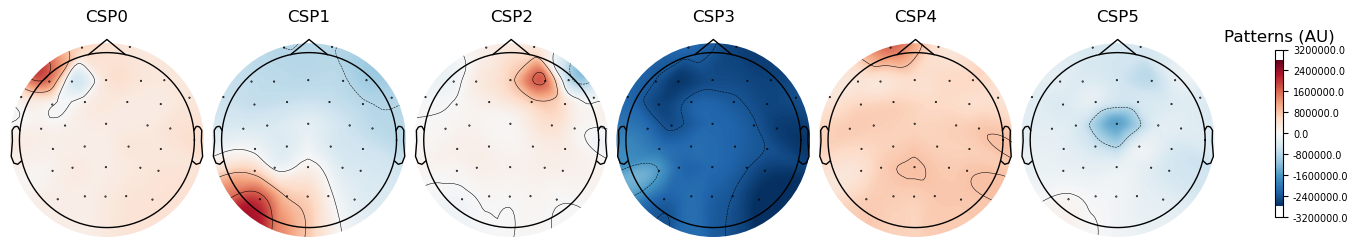

In [20]:
for csp in csp_list:
    csp.plot_patterns(train_epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

### Mulit-class CSP
- 